In [67]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from mecab import MeCab
from pymongo import MongoClient
import pandas as pd 

# 네트워크 연결 규칙 : protocol://ip:port/path 
client = MongoClient('mongodb://192.168.0.50:27017/')

db_name = client["DB_SGMN"]
collection = db_name["COL_SCRAPPING_TOSS_COMMENT_HISTORY"]


In [68]:
find_data = collection.find()
data_list = list(find_data)

In [69]:
df_data = pd.DataFrame(data_list)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251836 entries, 0 to 251835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   _id         251836 non-null  object        
 1   COMMENT     251836 non-null  object        
 2   CREATED_AT  251836 non-null  datetime64[ns]
 3   DATE        251836 non-null  object        
 4   DATETIME    251836 non-null  object        
 5   SYMBOL      251836 non-null  object        
 6   UPDATED_AT  251836 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 13.4+ MB


In [70]:
mecab_inst = MeCab()

In [71]:
# 주차 계산을 위한 함수 정의
def get_week(date_str):
    # 정규 표현식으로 연도와 월, 일을 추출
    match = re.match(r'(\d{4})-(\d{2})-(\d{2})', date_str)
    if match:
        year, month, day = map(int, match.groups())
        # 날짜 객체 생성
        date = pd.Timestamp(year=year, month=month, day=day)
        # ISO 주차 반환
        return date.isocalendar()[1]  # 주차
    return None


In [72]:
# DATE 열에서 주차 계산
df_data['WEEK'] = df_data['DATE'].apply(get_week)

# 주차별로 그룹화하여 집계 (예: VALUE의 합계)
weekly_data = df_data.groupby(['WEEK']).agg({'COMMENT': ' '.join}).reset_index()

# 결과 출력
print(weekly_data)

   WEEK                                            COMMENT
0    47  머선일이야 뭐냐 너..왜 희망 갖게하냐 몇개월 기다리다가 조금 올라서 뺏더니 잘 올...
1    49  계엄 실패 너무 아쉬운 사람 개추 👍👍👍 2024-12-04\n\n안녕하세요 존버꿀...
2    50  치매치료약 문열어주세요 현기증난단말이에요 하.. 14퍼 올랐는데 3만원밖에 안 넣어...
3    51  테슬라 흥행하면 꼭 자빠지네 브론즈 뱃지ㅣ단 듣보들이 차트분석을올린다?\n강력한 매...
4    52  오늘 진짜 궁금하네 ㅋㅋ 제가 올해 총 600 수익을 냈고\n지금 -330인데 팔아...


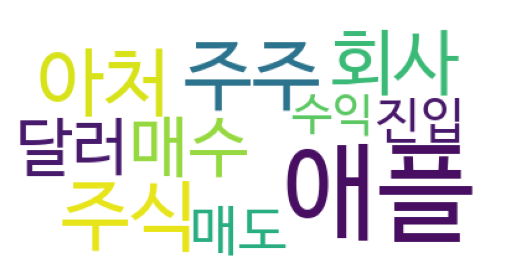

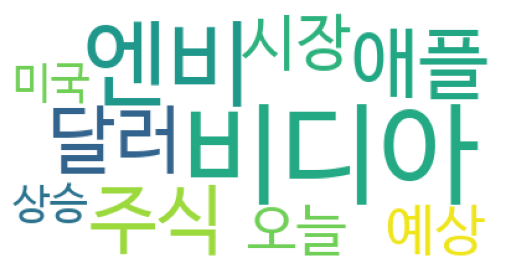

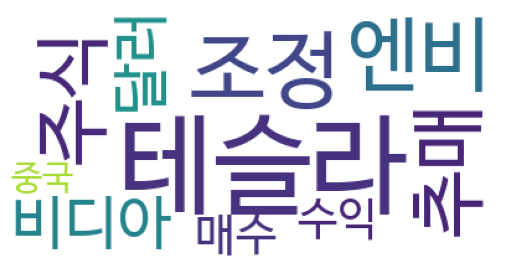

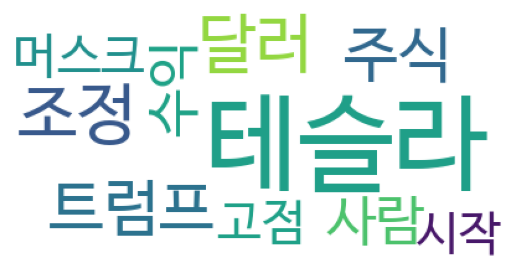

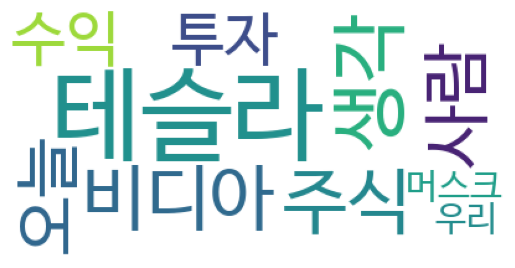

In [73]:
for text in weekly_data['COMMENT'].values:
    nouns_text = mecab_inst.nouns(text[:60000])
    filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
    
    counter_text_splits = Counter(filtered_nouns)
    counter_dict = dict(counter_text_splits.most_common()[:10])
    
    wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    wordcloud_instance.generate_from_frequencies(counter_dict) 

    plt.imshow(wordcloud_instance)
    plt.axis('off')
    plt.show()


In [74]:
def run_wordcloud(date_col_name, comment_col_name):
    df_data['WEEK'] = df_data[date_col_name].apply(get_week)
    weekly_data = df_data.groupby(['WEEK']).agg({comment_col_name: ' '.join}).reset_index()
    print(weekly_data)

    for text in weekly_data[comment_col_name].values:
        nouns_text = mecab_inst.nouns(text[:60000])
        filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]

        counter_text_splits = Counter(filtered_nouns)
        counter_dict = dict(counter_text_splits.most_common()[:10])

        wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
        wordcloud_instance.generate_from_frequencies(counter_dict) 

        plt.imshow(wordcloud_instance)
        plt.axis('off')
        plt.show()


   WEEK                                            COMMENT
0    47  머선일이야 뭐냐 너..왜 희망 갖게하냐 몇개월 기다리다가 조금 올라서 뺏더니 잘 올...
1    49  계엄 실패 너무 아쉬운 사람 개추 👍👍👍 2024-12-04\n\n안녕하세요 존버꿀...
2    50  치매치료약 문열어주세요 현기증난단말이에요 하.. 14퍼 올랐는데 3만원밖에 안 넣어...
3    51  테슬라 흥행하면 꼭 자빠지네 브론즈 뱃지ㅣ단 듣보들이 차트분석을올린다?\n강력한 매...
4    52  오늘 진짜 궁금하네 ㅋㅋ 제가 올해 총 600 수익을 냈고\n지금 -330인데 팔아...


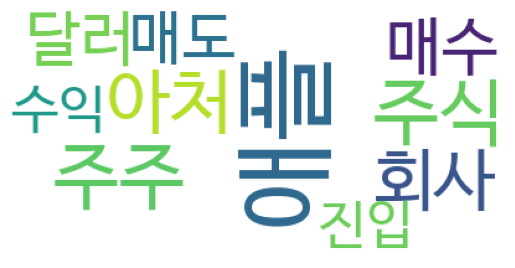

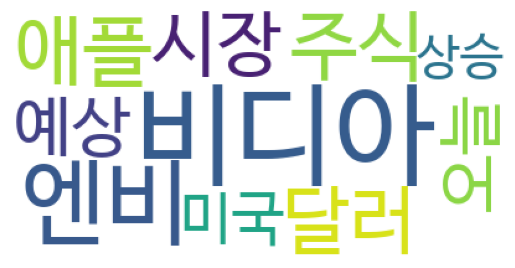

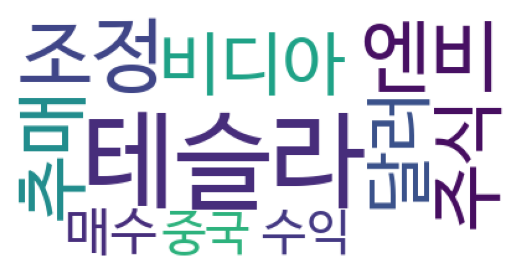

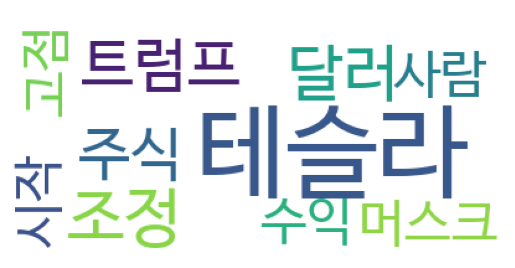

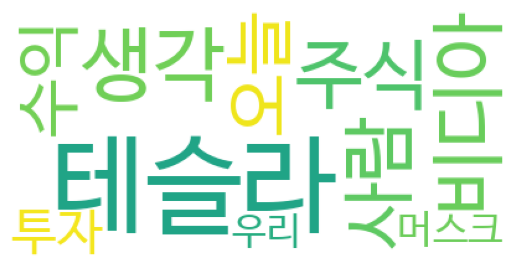

In [75]:
run_wordcloud('DATE','COMMENT')